# Middle Income Renters and Homeowners in California

Analysis to better understand the current economic state and composition of Middle Income Renters and Homeowners (80-120% of AMI) in California. 

Final paper here: https://ternercenter.berkeley.edu/wp-content/uploads/2022/04/Landscape-of-Middle-Income-Housing-Affordability-April-2022.pdf

The notebook is broken up into sections. Functions are kept within the notebook for ease of code review:

0. [Load and Clean ACS Household Data](#section0)

1. [Renter and Mortgage Holder Cost Burden Charts ](#section1)
    - Charts 3A and 3B, respectively, in the Missing Middle Brief 
2. [Load and Clean ACS Person Level Data](#section2)

3. [Trends in Entry Level Housing Prices](#section3)
    - Chart 5 in Missing Middle Brief 
    
4. [Share of Middle-Income Renters Paying More than 30% of Income in Rent, 2010 & 2019, by Race](#section4)
    - Chart 7 in Missing Middle Brief 
    
5. [Number of Home Purchase Loans Originated, by Race/Ethnicity, 2020](#section5)
    - Chart 8 in Missing Middle Brief 
 
 
Data from:
- 2019 and 2010 PUMS https://www2.census.gov/programs-surveys/acs/data/pums/
- HCD AMI Limits https://www.hcd.ca.gov/grants-funding/income-limits/state-and-federal-income-limits/docs/income-limits-2019.pdf
- Geography Crosswalks from MCDC http://mcdc.missouri.edu/applications/geocorr2018.html
- 2020 HMDA https://cfpb.github.io/hmda-platform/#hmda-api-documentation 

In [21]:
import pandas as pd
import numpy as np
import warnings
import wquantiles as wq
from statistics import mean
import os
import altair as alt
from urllib.request import urlopen
import zipfile
import altair_viewer
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

#NOTE only need below change to altair rendering to have static altair images render on github 
#b/c github scrubs javascript CAN REMOVE if running locally
#Also, if you do want this to work for some reason, need to have selenium/chromedriver installed 
alt.renderers.enable('altair_saver', fmts=['vega-lite', 'png'])

RendererRegistry.enable('altair_saver')

<div id="section0"></div>

# Load and Clean PUMS Data

In [2]:
def check_for_PUMS_download(filename,zip_location,zip_name,file_type_dict={}):
    """
    inputs:
        filename (str) - name of csv downloaded from PUMS 
        zip_location (str) - location of zip file (can edit URL for year/version of data)
        zip_name (str) - name of the zip file downloaded from the zip location to open 
        
    here checking to see if 2019 1-year PUMS data is in the current directory, if not, downloading and unzipping 
    it to the current directory (can place is somewhere else by modifying filepath of zip_directory)
    """
    if os.path.isfile(filename):
        df = pd.read_csv(filename,dtype=file_type_dict)
        return df
    else:
        PUMS_url = zip_location
        zip_directory = os.getcwd() 
        url = urlopen(PUMS_url)
        output = open(zip_name, 'wb')           
        output.write(url.read())
        output.close()
        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall(zip_directory)
        df = pd.read_csv(filename,dtype=file_type_dict)
    return df
file_type_dict = {"PUMA":str,"WGTP":float}
df_2019 = check_for_PUMS_download('./psam_h06.csv',
                                  "https://www2.census.gov/programs-surveys/acs/data/pums/2019/1-Year/csv_hca.zip",
                                  "./pums_2019.zip",file_type_dict)
df_2010 = check_for_PUMS_download('./ss10hca.csv',
                                  "https://www2.census.gov/programs-surveys/acs/data/pums/2010/1-Year/csv_hca.zip",
                                  './pums_2010.zip',file_type_dict)

In [3]:
#rename columns and only keep subset (extra cols were for some exploratory analysis) 
def rename_cols(df):
    """
    inputs:
        df (dataframe): PUMS data
    Renames columns with more verbose names and returns subset of columns
    """
    df.rename(columns={"RT":"record_type",
                     "TYPE":"type",
                     "BLD":"units_in_structure",
                     "BDSP":"number_bedrooms",
                     "RNTP":"monthly_rent",
                     "MRGP":"first_mortgage",
                     "SMP":"second_mortgage",
                     "TEN":"tenure",
                     "VACS":"vacancy_status",
                     "VALP":"property_value",
                     "GRPIP":"gross_rent_pct_of_income",
                     "GRNTP":"gross_rent",
                     "SMOCP":"select_owner_cost",
                     "OCPIP":"select_owner_cost_pct_of_income",
                     "HINCP":"hh_income",
                     "NP":"ppl_in_hh",
                     "NRC":"num_relate_chldrn",
                     "NOC":"num_own_chldrn",
                     "WGTP":"weight",
                     "YBL": "year_built",
                     }, inplace=True)

    df = df[["SERIALNO","hh_income","first_mortgage","select_owner_cost","gross_rent_pct_of_income",
             "select_owner_cost_pct_of_income","second_mortgage","ppl_in_hh",'PUMA',"gross_rent",
             "monthly_rent","weight","year_built","tenure","property_value"]]
    return df 

df_2019 = rename_cols(df_2019)
df_2010 = rename_cols(df_2010)
#to calc ami ranges we need household income, safely drop (this drop 16382 records from 2010;24148 from 2019 )
df_2019 = df_2019.dropna(subset=["hh_income"])
df_2010 = df_2010.dropna(subset=["hh_income"])

### Crosswalk and Weighting 

In [4]:
#import and clean a PUMA to county crosswalk from mcdc for both 2010 and 2019 (need both b/c pumas change)
def import_clean_crosswalk(location,county_col,puma_col):
    """
    inputs:
        location (str): Location of crosswalk csv
        county_col (str): name of column with counties 
        puma_col (str): name of column with PUMAs
    Reads in and cleans up crosswalk files from geocorr, returning subset of columns
    """
    #PUMA - County Crosswalk URL generated from https://mcdc.missouri.edu/applications/geocorr2018.html with puma12 & county14
    crosswalk_county = pd.read_csv(location)
    crosswalk_county = crosswalk_county.iloc[1:]
    crosswalk_county["afact"] = crosswalk_county["afact"].astype(float)
    crosswalk_county[county_col] = crosswalk_county[county_col].str.replace(r' CA', '')
    crosswalk_county = crosswalk_county[[puma_col,county_col,"afact"]]
    crosswalk_county.rename(columns={puma_col:"PUMA",county_col:"County"},inplace=True)
    return crosswalk_county

#create PUMA county crosswalk for the seperate years 
crosswalk_county_2019 = import_clean_crosswalk("geocorr2018_2115904557.csv",'cntyname2',"puma12")
crosswalk_county_2010 = import_clean_crosswalk("geocorr_old_pumas.csv","cntyname","puma2k")

In [5]:
def crosswalk_weighting(df,crosswalk,geo_type,split_col):
    """
    inputs:
        df (dataframe): PUMS data 
        crosswalk (dataframe): crosswalk of PUMAs to Counties with weights 
        puma_col (str): name of column with PUMAs
        geo_type (str): name of column of type of geography to match on
        split_col(str or list): name of column being split across geographies. 
        Can also be passed as a list of multiple cols 
                                
    Takes a df with a geography and target value(s), and crosswalks to a many to many 
    mapping and multiplies by the weights.
    This is simplisitic and assumes that you can split your split_col evenly based on the 
    weighting across a given geography which is likely unrealistic. 
    """
    weighted_crosswalks = crosswalk[crosswalk.afact != 0]
    weighted_crosswalks_PUMA = weighted_crosswalks[geo_type].unique()
    df_weighted = df[df[geo_type].isin(weighted_crosswalks_PUMA)]
    df_weighted = df_weighted.merge(weighted_crosswalks, on=geo_type,how="left")
    if isinstance(split_col,list):
        for i in split_col:
            df_weighted[i] = df_weighted[i] * df_weighted["afact"]
            df_weighted = df_weighted[df_weighted[i] != 0]

    elif isinstance(split_col,str):
        df_weighted[split_col] = df_weighted[split_col] * df_weighted["afact"]
        df_weighted = df_weighted[df_weighted[split_col] != 0]
    else:
        print(type(split_col)," is wrong type for split_col")

    full_data = df_weighted.drop_duplicates()
    return full_data

df_2019 = crosswalk_weighting(df_2019,crosswalk_county_2019,"PUMA","weight")
df_2010 = crosswalk_weighting(df_2010,crosswalk_county_2010,"PUMA","weight")

In [6]:
#merge on AMI bands for county/year/household size combos
AMI=pd.read_csv("CA_AMI_wide.csv")#csv with HCD AMI Bands from HCD website 
AMI=AMI[AMI.year.isin([2010,2019])]
#reshape data 
amelti = AMI.melt(id_vars=['county_name',  'year'])
amelti['hh'] = amelti.variable.apply(lambda x: x.split('_')[0])
amelti['idk'] = amelti.variable.apply(lambda x: x.split('_')[1])
amelti = amelti.pivot_table(index=['county_name','year', 'hh'], columns=['idk'], values='value').reset_index()
amelti['ppl_in_hh'] = amelti.hh.apply(lambda x: int(x.replace('hh','')))
#adjust for a weird quick in AMI calculations where sometimes 80% AMI is higher than 100% AMI
amelti["LI80"] = np.where(amelti["LI80"] > amelti["MED100"],amelti["MED100"],amelti["LI80"])

In [7]:
#merge 2010 and 2019 data 
df_2010['year'] = 2010
df_2019['year'] = 2019
df = df_2010.append(df_2019, ignore_index=True)

### Calculate weighted percentage of renters and homeowners that are cost burdened 

In [8]:
def calc_burdern(df,variable,final_variable_name,mid=False):
    """
    Inputs:
        df (dataframe) - PUMS data
        variable (str) - name of PUMS variable to check for financial burden
                         in this likely gross_rent or select_owner_cost
        final_variable_name (str) - name of new column for type of burden 
        mid (bool) - True if you want to filter for just middle income, false if want all AMI Bands 
    Calculate percent burdended (>30 of income to rent or home ownership costs) of each AMI Band, filtering for just 
    middle income in mid=True
    """
    df = df.dropna(subset=["hh_income",variable])
    df = df[df['hh_income'] >=0] #drop negative hh income  
    df = df[(df.gross_rent != ' ')] 
    df = pd.merge(df, amelti, on=[ 'year', 'ppl_in_hh'], how='left')
    df['elow_income'] = np.where((df["hh_income"] < df["ELI30"]), 1, 0)
    df['vlow_income'] = np.where((df["hh_income"] >= df["ELI30"])&(df["hh_income"] < df["VLI50"]), 1, 0)
    df['low_income'] = np.where((df["hh_income"] >= df["VLI50"])&(df["hh_income"] < df["LI80"]), 1, 0)
    df['middle_income'] = np.where((df["hh_income"] >= df["LI80"])&(df["hh_income"] < df["MOD120"]), 1, 0)
    df['high_income'] = np.where((df["hh_income"] >= df["MOD120"]), 1, 0)
    if mid == True:
        df = df[df.middle_income==1]
    df['monthly_income'] = df.hh_income/12
    df[variable+'_percent'] = df[variable]/df['monthly_income']
    df[final_variable_name] = np.where(df[variable+'_percent']>.3,1,0)
    return df
    
df_mid_mortgage_burden = calc_burdern(df,"select_owner_cost",'Mortgage_Burdened',mid=True)    
df_mid_rent_burden = calc_burdern(df,"gross_rent",'Rent_Burdened',mid=True)  

df_mortgage_burden_chart = calc_burdern(df,"select_owner_cost",'Mortgage_Burdened',mid=False)
df_rent_burden_chart = calc_burdern(df,"gross_rent",'Rent_Burdened',mid=False)

In [9]:
#the below reshapes data to make bar charts 

def status_col(burden,sev_burden):
    """
    Small lambda function to return strings stating burden status 
    """
    if sev_burden == 1:
        return "Share Severely Burdened"
    if burden==1:
        return "Share Burdened"
    else:
        return "Not Burdened"

def make_income_chart_correct(df,variable,input_year,chart3=True):
    """
    inputs:
        df (dataframe): PUMS data
        variable (str): Which variable (rent or mortgage) that you want to calculate share burdened for. 
        input_year (int): Which year to be analyized (in current format of notebook, either 2010 or 2019)
    Returns data in correct format for bar chart
    
    """
    df = df[df.year == input_year]
    df["Share Burdened"] = np.where((df[variable] > .3)&(df[variable] <= .5),1,0)
    df["Share Severely Burdened"] = np.where(df[variable] > .5,1,0)
    #if variable == "gross_rent_percent":
    #    df = df[df.tenure==1]
    
    if chart3 == True:
        meltby = ['Share Burdened', 'Share Severely Burdened']
        county_col = []
    else:
        meltby = ['Share Burdened', 'Share Severely Burdened',"county_name"]
        county_col = ["county_name"]
    df_graph = df[["weight",'elow_income', 'vlow_income', 'low_income', 'middle_income',
           'high_income', 'Share Burdened', 'Share Severely Burdened']+county_col]
    income_types = ['elow_income', 'vlow_income', 'low_income', 'middle_income','high_income']
    df_graph[income_types] = df_graph[income_types].multiply(df_graph["weight"], axis="index") 
    df_graph = df_graph.drop(columns=["weight"])
    df_graph = df_graph.melt(id_vars=meltby)
    df_graph = df_graph.groupby(["Share Burdened","Share Severely Burdened","variable"]+county_col).sum().reset_index()

    df_graph['Status'] = df_graph[["Share Burdened","Share Severely Burdened"]].apply(lambda x: status_col(x["Share Burdened"],x["Share Severely Burdened"]), axis=1)
    df_graph.drop(columns=["Share Burdened","Share Severely Burdened"],inplace=True)

    df_graph = df_graph.groupby(["variable","Status"]).sum()
    df_graph["percent"] = df_graph.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    df_graph = df_graph.reset_index()

    df_graph_totals = df_graph.groupby("Status").sum().reset_index()
    df_graph_totals["percent"] = (df_graph_totals["value"]/df_graph_totals["value"].sum())*100
    df_graph_totals["variable"] = "Total"
    final_graph = pd.concat([df_graph,df_graph_totals])
    final_graph["year"] = input_year
    final_graph.replace({"variable":{'elow_income':"Extremely Low Income", 
                                    'high_income':"High Incomes", 
                                    'low_income':"Low Income", 
                                    'middle_income':"Middle Income",
                                    'vlow_income':"Very Low Income", 
                                    'Total':"All Incomes"}},inplace=True)
    final_graph = final_graph[final_graph.variable !="High Incomes"]
    final_graph = final_graph[final_graph.Status !="Not Burdened"]  
    
    if variable == "gross_rent_percent":
        final_graph["Household Type"] = "Renter"
        
    if variable == "select_owner_cost_percent":
        final_graph["Household Type"] = "Mortgage Holder"
    
    return final_graph 

#call function to make bar chart shaped data for renters and homeowners 
pivot_rent_2010 =make_income_chart_correct(df_rent_burden_chart,"gross_rent_percent",2010)
pivot_rent_2019 =make_income_chart_correct(df_rent_burden_chart,"gross_rent_percent",2019)

pivot_mortgage_2010 =make_income_chart_correct(df_mortgage_burden_chart,"select_owner_cost_percent",2010)
pivot_mortgage_2019 =make_income_chart_correct(df_mortgage_burden_chart,"select_owner_cost_percent",2019)

#combine 2010 and 2019 data 
all_together = pd.concat([pivot_rent_2019,pivot_rent_2010,pivot_mortgage_2010,pivot_mortgage_2019])
all_together.rename(columns={"value":"Total Households",
                            "variable":"AMI"},inplace=True)
all_together["Total Households"] = all_together["Total Households"].round(0)

all_together_renter = all_together[all_together["Household Type"]=="Renter"]
all_together_owner = all_together[all_together["Household Type"]=="Mortgage Holder"]
all_together_renter = all_together_renter[all_together_renter.AMI == "Middle Income"]

<div id="section1"></div>

# Renter and Homeowner Cost Burden 

### Figure 3A 

In [10]:
df_mortgage_burden_chart_total_count = df_mortgage_burden_chart[df_mortgage_burden_chart.year == 2019]

In [11]:
#calculate total number of renters and owners 
number_owners = df_2019[["tenure","weight"]].groupby("tenure").sum().reset_index()[0:2]["weight"].sum()
number_renters = df_2019[["tenure","weight"]].groupby("tenure").sum().reset_index()[2:3]["weight"].sum()

In [12]:
#calculate total percentage of owners and renters, respectively, that were cost burdened 
total_percent_owners_cost_burdened = pivot_mortgage_2019[pivot_mortgage_2019["variable"] == "All Incomes"]["percent"].sum()
total_percent_renter_cost_burdened = pivot_rent_2019[pivot_rent_2019["variable"] == "All Incomes"]["percent"].sum()

In [13]:
#calculate total number of burdened renters and owners 
number_cost_burdened_renters = (total_percent_renter_cost_burdened/100) *number_renters
number_cost_burdened_owners = (total_percent_owners_cost_burdened/100)*number_owners
total_burdened = number_cost_burdened_owners +number_cost_burdened_renters

In [14]:
#this is the percent of all households, renters or owners, that are cost burdened in 2019
total_burdened/df_2019["weight"].sum()#note, not that outcome changes very much
#this uses the total of all tenure types, includes the 171,392 households that
#who housing is "Occupied without payment of rent". Technically, these households are not cost burdened 
#as they pay no cost, so keeping them in denominator seemed reasonable 

0.39499704992317086

In [15]:
pivot_rent_2019["percentage_for_chart"] = (pivot_rent_2019["percent"]/100).round(2)
pivot_rent_2019["text"] = pivot_rent_2019["percentage_for_chart"]
big_cols = pivot_rent_2019.groupby(["variable"]).sum().reset_index()[["variable","percentage_for_chart"]]
dict3a = dict(zip(big_cols["variable"],big_cols["percentage_for_chart"]))

pivot_rent_2019.at[2,"text"] = dict3a["Extremely Low Income"]
pivot_rent_2019.at[8,"text"] = dict3a["Low Income"]
pivot_rent_2019.at[11,"text"] = dict3a["Middle Income"]
pivot_rent_2019.at[14,"text"] = dict3a["Very Low Income"]

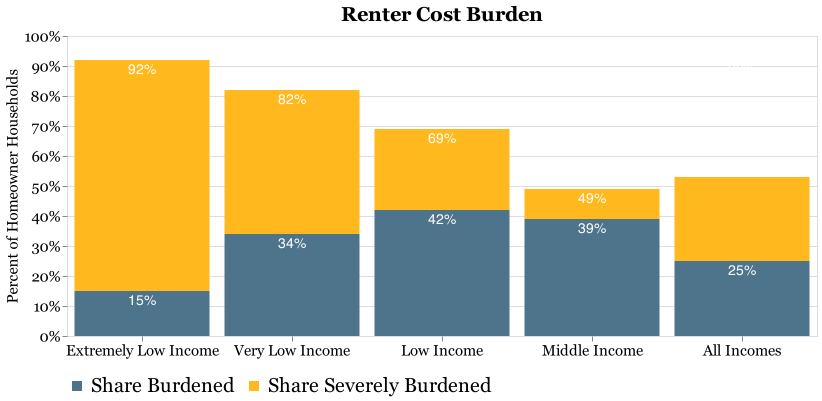

In [39]:
bars3a = alt.Chart(pivot_rent_2019).mark_bar().encode(
    alt.X('variable:O',sort=["Extremely Low Income", "Very Low Income", "Low Income", 
                             "Middle Income", "All Incomes"],title="",axis=alt.Axis( labelAngle=360)),
    y=alt.Y('percentage_for_chart:Q',
            axis=alt.Axis(format='%'),sort=["Share Burdened",
  "Share Severely Burdened"],title="Percent of Homeowner Households", scale=alt.Scale(domain=[0, 1])),
    color=alt.Color("Status",sort=["Share Burdened",
                                   "Share Severely Burdened",],
                    title=None,scale=alt.Scale(domain=["Share Burdened",
                                                       "Share Severely Burdened"],
                                               range=["#4E748B","#FFB81D"])),
    order=alt.Order(
      'Status',
      sort='ascending'
    ))

text3a = alt.Chart(pivot_rent_2019).mark_text(fontSize = 14,color='white',dy=10).encode(
    x=alt.X('variable:O',sort=["Extremely Low Income", "Very Low Income", "Low Income", "Middle Income"]),
    y=alt.Y('text:Q'),
    detail='text:O',
    text=alt.Text('text:O',format='~%'),
    opacity=alt.condition( 'datum.text < 43', alt.value(1), alt.value(0)
))

text2 = alt.Chart(pivot_rent_2019).mark_text(fontSize = 14,color='white',dy=8).encode(
    x=alt.X('variable:O',sort=["Extremely Low Income", "Very Low Income", "Low Income", "Middle Income"]),
    y=alt.Y('text:Q'),
    detail='text:O',
    text=alt.Text('text:O',format='~%'),
    opacity=alt.condition( 'datum.text > 43 ', alt.value(1), alt.value(0)
))

layer = alt.layer(
    bars3a,
    text3a,text2).properties(
    title={
      "text": ["Renter Cost Burden"]}).configure_legend(orient="bottom",
labelLimit= 0,titleLimit=0,titleFontSize=18,
labelFontSize=20,labelFont="Georgia",titleFont="Georgia").configure_axis(domain=False,labelFont='Georgia',
titleFont='Georgia',
titleFontWeight="normal",labelFontSize=15,titleFontSize=15).properties(
    width=750).configure_title(fontSize=20,anchor="middle",font="Georgia")

layer

### Figure 3B

In [26]:
pivot_mortgage_2019["percentage_for_chart"] = (pivot_mortgage_2019["percent"]/100).round(2)
pivot_mortgage_2019["text"] = pivot_mortgage_2019["percentage_for_chart"]
big_cols = pivot_mortgage_2019.groupby(["variable"]).sum().reset_index()[["variable","percentage_for_chart"]]
dict3a = dict(zip(big_cols["variable"],big_cols["percentage_for_chart"]))

pivot_mortgage_2019.at[2,"text"] = dict3a["Extremely Low Income"]
pivot_mortgage_2019.at[8,"text"] = dict3a["Low Income"]
pivot_mortgage_2019.at[11,"text"] = dict3a["Middle Income"]
pivot_mortgage_2019.at[14,"text"] = dict3a["Very Low Income"]

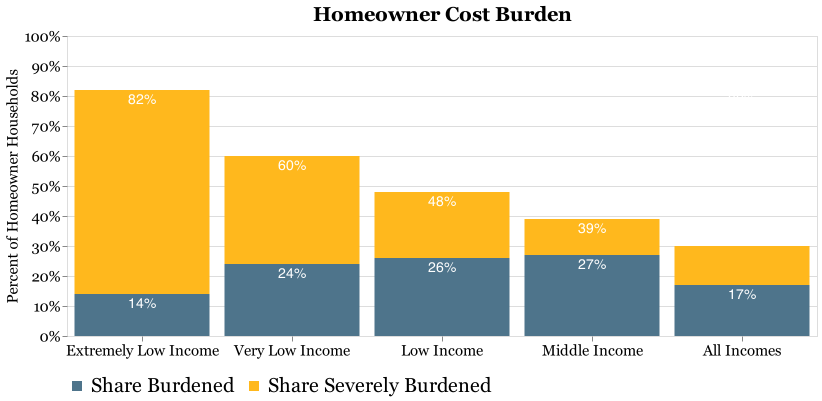

In [40]:
chart3b = alt.Chart(pivot_mortgage_2019).mark_bar().encode(
    alt.X('variable:O',sort=["Extremely Low Income", "Very Low Income", "Low Income", 
                             "Middle Income", "All Incomes"],title="",axis=alt.Axis( labelAngle=360)),
    y=alt.Y('percentage_for_chart:Q',axis=alt.Axis(format='%'),sort=["Share Burdened",
        "Share Severely Burdened"],title="Percent of Homeowner Households", scale=alt.Scale(domain=[0, 1])),
    color=alt.Color("Status",sort=["Share Burdened",
                                   "Share Severely Burdened",],
                    title=None,scale=alt.Scale(domain=["Share Burdened",
                                                       "Share Severely Burdened"],
                                               range=["#4E748B","#FFB81D"])),
    order=alt.Order(
      'Status',
      sort='ascending'
    ))


text3b = alt.Chart(pivot_mortgage_2019).mark_text(fontSize = 14,color='white',dy=10).encode(
    x=alt.X('variable:O',sort=["Extremely Low Income", "Very Low Income", "Low Income", "Middle Income"]),
    y=alt.Y('text:Q'),
    detail='text:O',
    text=alt.Text('text:O',format='~%'),
    opacity=alt.condition( 'datum.text < 30', alt.value(1), alt.value(0)
))

text2b = alt.Chart(pivot_mortgage_2019).mark_text(fontSize = 14,color='white',dy=-20).encode(
    x=alt.X('variable:O',sort=["Extremely Low Income", "Very Low Income", "Low Income", "Middle Income"]),
    y=alt.Y('text:Q'),
    detail='text:O',
    text=alt.Text('text:O',format='~%'),
    opacity=alt.condition( 'datum.text > 30 ', alt.value(1), alt.value(0)
))

layer = alt.layer(
    chart3b,
    text3b,text2b).properties(
    title={
      "text": ["Homeowner Cost Burden"]}).configure_legend(orient="bottom",labelPadding=100, 
                labelLimit= 0,titleLimit=0,titleFontSize=18,
labelFontSize=20,labelFont="Georgia",titleFont="Georgia").configure_axis(domain=False,
labelFont='Georgia',titleFont='Georgia',titleFontWeight="normal",labelFontSize=15,titleFontSize=15).properties(
    width=750
).configure_title(fontSize=20,font="Georgia")

layer

<div id="section3"></div>

## Figure 5: Trends in Entry Level Housing Prices 

In [41]:
zillow_zhvi_low_tier_link = "https://files.zillowstatic.com/research/public_csvs/zhvi/City_zhvi_uc_sfrcondo_tier_0.0_0.33_sm_sa_month.csv?t=1644951038"
zillow_zhvi_low_tier = pd.read_csv(zillow_zhvi_low_tier_link)
low_tier_ca = zillow_zhvi_low_tier[zillow_zhvi_low_tier.StateName == "CA"]
low_tier_ca = low_tier_ca[low_tier_ca.RegionName.isin(["Los Angeles","San Francisco","Sacramento"])]
year_cols = list(low_tier_ca.columns[low_tier_ca.columns.str.contains(r'2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021')])
low_tier_ca = low_tier_ca[["RegionName"]+year_cols]
low_tier_ca = low_tier_ca.melt("RegionName")
low_tier_ca["value_trun"] = low_tier_ca["value"]/1000

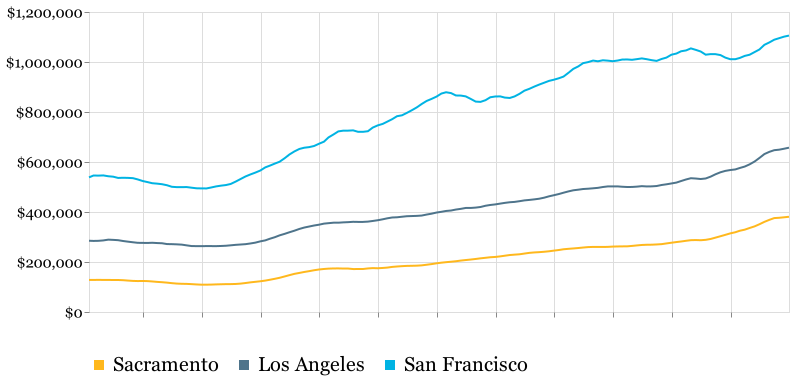

In [42]:
alt.Chart(low_tier_ca).mark_line().encode(
    alt.X('variable:T',title=" ",axis=alt.Axis( labelAngle=-45,labels=False)),
    alt.Y('value',title="",
          axis=alt.Axis(values=[0, 200000, 400000, 600000, 800000,1000000,1200000],format="$,f")),
    color=alt.Color('RegionName:O',title="",scale=alt.Scale(domain=[
                        "Sacramento","Los Angeles","San Francisco"],range=["#FFB81D","#4E748B","#00B3E3",
]))).configure_legend(orient="bottom",labelLimit= 0,titleLimit=0,titleFontSize=18,symbolStrokeWidth=10,
labelFontSize=20,labelFont="Georgia",titleFont="Georgia").configure_axis(domain=False,
labelFont='Georgia',titleFont='Georgia',titleFontWeight="normal",labelFontSize=15,titleFontSize=15).properties(
    width=700
)


<div id="section4"></div>

## Figure 7: Share of Middle-Income Renters Paying More than 30% of Income in Rent, 2010 & 2019, by Race

In [43]:
#get individual level PUMS data (above we were using household level)
df_2019_person = check_for_PUMS_download('./psam_p06.csv',"https://www2.census.gov/programs-surveys/acs/data/pums/2019/1-Year/csv_pca.zip","./pums_2019.zip")

#filter for adults, relabel race data 
df_2019_person_over_18 = df_2019_person[df_2019_person.AGEP>=18]
def fix_race(race,ethnicity):
    """
    used in a lambda function to combine race and ethnicity columns in eden demographic data 
    """
    if ethnicity > 1:
        return "Hispanic"
    elif race == 1:
        return "NH White"
    elif race == 6:
        return "NH Asian"
    elif race == 2:
        return "NH Black"
    else:
        return "Other"
df_2019_person_over_18["Race_Coded"] = df_2019_person_over_18.apply(lambda x: fix_race(x.RAC1P,x.HISP),axis=1)
df_2019_person_over_18["person_id"] = np.arange

In [44]:
#get individual level PUMS data (above we were using household level)
df_2019_person = check_for_PUMS_download('./psam_p06.csv',
    "https://www2.census.gov/programs-surveys/acs/data/pums/2019/1-Year/csv_pca.zip","./pums_2019.zip")

#filter for adults, relabel race data 
df_2019_person_over_18 = df_2019_person[df_2019_person.AGEP>=18]
def fix_race(race,ethnicity):
    """
    used in a lambda function to combine race and ethnicity columns in eden demographic data 
    """
    if ethnicity > 1:
        return "Hispanic"
    elif race == 1:
        return "NH White"
    elif race == 6:
        return "NH Asian"
    elif race == 2:
        return "NH Black"
    else:
        return "Other"
df_2019_person_over_18["Race_Coded"] = df_2019_person_over_18.apply(lambda x: fix_race(x.RAC1P,x.HISP),axis=1)
df_2019_person_over_18["person_id"] = np.arange

#here I am keeping only heads of household to mark as household race 
df_2019_person_over_18=df_2019_person_over_18[df_2019_person_over_18["RELSHIPP"] == 20]
df_2019_person_over_18 = df_2019_person_over_18[["SERIALNO","Race_Coded","WAGP"]]
#sort by serialno, wage desc, and then drop duplicates on serial no 
#household_race = df_2019_person_over_18[["SERIALNO","Race_Coded","WAGP"]].sort_values(["SERIALNO","WAGP"],ascending=False).drop_duplicates(subset="SERIALNO")

merged = df_2019.merge(df_2019_person_over_18,on="SERIALNO")

#make tenure verbose
merged.replace({"tenure":{1:"Owned with Mortgage",2:"Owned Free and Clear",
                          3:"Rented",4:"Occupied without Payment of Rent"}},inplace=True)

merged['county_name'] = merged.County + " County"
#merge on AMI data, cleaned above for use in charts 3
merged_AMI = pd.merge(merged, amelti, on=['county_name', 'ppl_in_hh'], how='left')

#filter for 2019 
merged_AMI = merged_AMI[merged_AMI.year_y == 2019]

def label_ami_band(ELI30,VLI50,LI80,MED100,MOD120,hh_income):
    if hh_income <= ELI30:
        return "ELI"
    if hh_income <= VLI50:
        return "VLI"
    if hh_income <= LI80:
        return "LI"
#    if hh_income <= MED100:
#        return "MED"
    if hh_income <= MOD120:
        return "MOD"
    else:
        return "HIGH"
    
#label income bands 
merged_AMI['income_band_label'] = merged_AMI.apply(lambda x: label_ami_band(x.ELI30,x.VLI50,x.LI80,
                                                                            x.MED100,x.MOD120,x.hh_income), axis=1)

#filter for middle income
merged_AMI = merged_AMI[["Race_Coded","weight","county_name","income_band_label","tenure","hh_income"]]
merged_AMI_mid = merged_AMI[merged_AMI.income_band_label == "MOD"]
merged_AMI_mid = merged_AMI_mid.loc[:,~merged_AMI_mid.columns.duplicated()]
merged_AMI_mid = merged_AMI_mid[merged_AMI_mid.tenure != "Occupied without Payment of Rent"]
merged_AMI_mid = merged_AMI_mid[["Race_Coded","tenure","weight"]].groupby(["Race_Coded","tenure"]).sum().reset_index()
merged_AMI_mid_race_totals = merged_AMI_mid.groupby(["Race_Coded"]).sum().reset_index()
merged_AMI_mid = merged_AMI_mid.merge(merged_AMI_mid_race_totals,on="Race_Coded",how="left")
merged_AMI_mid["percentage"] = (merged_AMI_mid["weight_x"]/merged_AMI_mid["weight_y"])*100
merged_AMI_mid = merged_AMI_mid.drop(columns=["weight_x","weight_y"])
merged_AMI_mid_renter = merged_AMI_mid[merged_AMI_mid.tenure == "Rented"]
merged_AMI_mid_renter.replace({"Race_Coded":{"NH Asian":"Non-Hispanic Asian",
                                            "NH Black":"Non-Hispanic Black",
                                            "NH White":"Non-Hispanic White"}},inplace=True)

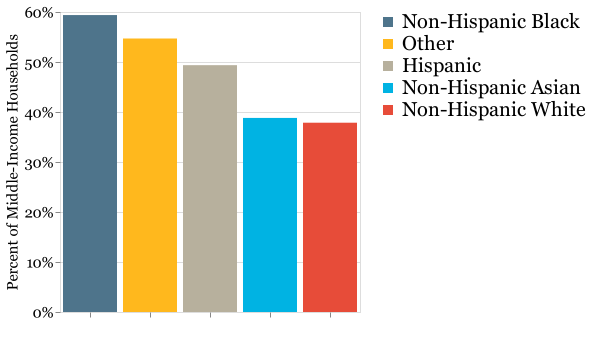

In [45]:
merged_AMI_mid_renter["percentage_for_chart"] = merged_AMI_mid_renter["percentage"]/100
alt.Chart(merged_AMI_mid_renter).mark_bar().encode(
    alt.X('Race_Coded:O',title=" ",sort="-y",axis=alt.Axis( labelAngle=-45,labels=False)),
    alt.Y('percentage_for_chart',title=["Percent of Middle-Income Households"],
          axis=alt.Axis(format='%')),
    color=alt.Color('Race_Coded:O',title="",scale=alt.Scale(domain=[
                        "Non-Hispanic Black","Other","Hispanic",
                        "Non-Hispanic Asian",
                        "Non-Hispanic White"],range=["#4E748B","#FFB81D",
"#B7B09D","#00B3E3","#E74C39"]))).configure_legend(direction="vertical",labelLimit= 0,titleLimit=0,titleFontSize=18,
labelFontSize=20,labelFont="Georgia",
titleFont="Georgia").configure_axis(domain=False,labelFont='Georgia',titleFont='Georgia',
titleFontWeight="normal",labelFontSize=15,titleFontSize=15).properties(width=300)

<div id="section5"></div>

## Figure 8: Number of Home Purchase Loans Originated, by Race/Ethnicity, 2020

In [46]:
def read_in_and_clean_hdma_data(df):
    """
    inputs:
        df (dataframe)

    various filters for HMDA data, described in-line 

    """
    df = df[df.derived_loan_product_type.isin(["Conventional:First Lien","FHA:First Lien",
                                           "VA:First Lien","FSA/RHS:First Lien"])] #first lien types 
    df = df[df.business_or_commercial_purpose == 2] #Not primarily for a business or commercial purpose
    df = df[df.loan_purpose == 1] #Home purchase
    df = df[df.total_units.isin([1,2,3,4])] #dwelling type 
    df = df[df.occupancy_type == 1]  #Principal residence
    df = df[df.action_taken == 1]  #loan actually originated
    return df

In [47]:
#check to see if HMDA data in current filepath, if not call API 
if os.path.isfile('./hmda_MM_2020.csv'):
    hmda = pd.read_csv("hmda_MM_2020.csv")
else:
    #read in hmda data 
    url = "https://ffiec.cfpb.gov/v2/data-browser-api/view/csv?states=CA&years=2020&actions_taken=1"
    hmda = pd.read_csv(url)
    hmda = read_in_and_clean_hdma_data(hmda)
    hmda.to_csv("hmda_MM_2020.csv")

In [48]:
#filter out 42,469 loans for which we don't have race and/or ethnicity data 
hmda = hmda[(hmda["derived_race"] != "Race Not Available")|(hmda["derived_ethnicity"]!="Ethnicity Not Available")]

In [50]:
#using codes from  https://s3.amazonaws.com/cfpb-hmda-public/prod/help/2018-public-LAR-code-sheet.pdf 
#simplifying racial and ethnic categorie available 
ethnicity = {1:"Hispanic",
            11:"Hispanic",12:"Hispanic",13:"Hispanic",
            14:"Hispanic",2:"Hispanic",
            3:"Information not provided by applicant",
            4:"Not Applicable"}
race = {1:"Other",
        2:"Asian",21:"Asian",22:"Asian",
        23:"Asian",24:"Asian",25:"Asian",
        26:"Asian",27:"Asian",3:"Black",
        4:"Other",41:"Other",42:"Other",
        43:"Other",44:"Other",5:"White",
        6:"Not Applicable"}

def hispanic(x,y):
    if x =="White":
        if y == 'Hispanic or Latino':
            return "Hispanic"
        else:
            return x
    else:
        return x
     
hmda["race"] = hmda.apply(lambda x: hispanic(x.derived_race,x.derived_ethnicity), axis=1)

race_map = {'White':"Non-Hispanic White", 
 'Race Not Available':"dropme",
 'Asian':"Non-Hispanic Asian", 
 'Hispanic':"Hispanic",
 'Black or African American':"Non-Hispanic Black",
 'Joint':"Other",
 'American Indian or Alaska Native':"Other",
 'Native Hawaiian or Other Pacific Islander':"Other", 
 '2 or more minority races':"Other",
 'Free Form Text Only':"dropme"}
hmda["race"] = hmda["race"].map(race_map)

In [51]:
#keep only race categories we want for chart 
hmda = hmda[hmda["race"].isin(['Hispanic','Non-Hispanic White',
        'Non-Hispanic Asian','Non-Hispanic Black', "Other"])]
hmda["unique_id"] = np.arange(hmda.shape[0])#create unique id for each row
hmda_chart = hmda[["race","unique_id"]]#filter for just race and unique_id

In [53]:
#get counts by category 
hmda_chart = hmda_chart.race.value_counts(normalize=True).reset_index()
hmda_chart.rename(columns={"index":"race_cat",
                          "race":"count"},inplace=True)

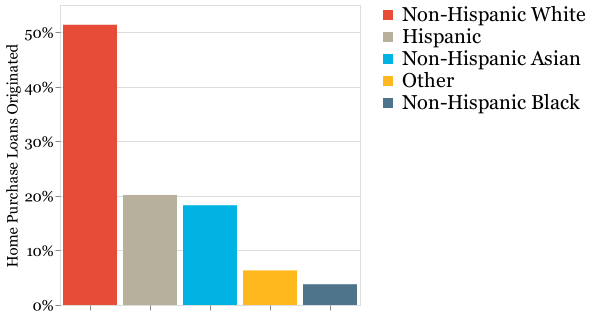

In [54]:
alt.Chart(hmda_chart).mark_bar().encode(
    alt.X('race_cat:O',title=" ",sort=["Non-Hispanic White","Hispanic",
        "Non-Hispanic Asian","Two or More Races","Other","Non-Hispanic Black",
        ],axis=alt.Axis(labels=False)),
    alt.Y('count:Q',title=["Home Purchase Loans Originated"],
          axis=alt.Axis(format='%',values=[0, .10, .20, .30, .40,.50,.60])),
    color=alt.Color('race_cat:O',title="",
scale=alt.Scale(domain=["Non-Hispanic White","Hispanic",
        "Non-Hispanic Asian","Other","Non-Hispanic Black"
        ],
    range=["#E74C39","#B7B09D","#00B3E3","#FFB81D","#4E748B"]))).configure_legend(direction="vertical",
                                labelLimit= 0,titleLimit=0,titleFontSize=18,
labelFontSize=20,labelFont="Georgia",titleFont="Georgia").configure_axis(domain=False,
        labelFont='Georgia',titleFont='Georgia',titleFontWeight="normal",labelFontSize=15,
        titleFontSize=15).properties(width=300)